## Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Calculate Time and Volume Bars

In the previous unit, we discussed the difference between time and volume bars. You have also learnt to create time and volume bars to calculate order flow using bulk volume classification. In this notebook, you will learn to create time and volume bars from tick data. 

The notebook is structured as follows:
1. [Read the Data](#data)
1. [Create Time Bars](#timebars)
1. [Plot Time Bars](#plottimebars)
1. [Create Volume bars](#volumebars)
1. [Plot the Volume Bars](#plotvolumebars)
1. [Conclusion](#conclusion)

## Import Libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# For plotting
import matplotlib.pyplot as plt
import mplfinance as mpf

<a id='data'></a>
## Read the Data
Import the pickle file `tick_data_es500_2013_10_02.bz2` as the dataframe `tick_data`. This pickle file has tick data and best bid, ask data of 	E-mini S&P 500 futures for the date `2013-10-02`. This dataset has columns `bid`, `ask`, `trade_price` and `trade_size` with datetime in milliseconds as the index.

**Note:** _The python version 3.9.5 and pandas version 1.4.4 were used to create this pickle file. To avoid issues reading this pickle file, ensure that the python and pandas versions are equal or higher than the versions mentioned._

In [2]:
# Read the 'tick_data_es500_2013_10_02.bz2' pickle file as 'tick_data' dataframe
tick_data = pd.read_pickle('../data_modules/tick_data_es500_2013_10_02.bz2')

# Print first 5 trades of the 'tick_data' dataframe
tick_data.head()

,bid,ask,trade_price,trade_size
,,,,
2013-10-02 00:00:00.604800,1428.50,1428.75,1428.75,1.0
2013-10-02 00:00:10.972800,1428.50,1428.75,1428.75,25.0
2013-10-02 00:00:19.439999,1428.50,1428.75,1429.00,17.0
2013-10-02 00:00:19.439999,1428.50,1428.75,1429.00,11.0
2013-10-02 00:00:19.526400,1428.75,1429.00,1429.00,28.0


<a id='timebars'></a>
## Create Time Bars
The time bars display price movements over a set time interval, such as a minute, hour, day, or week. 

### Resample to 100 millisecond bars

Let's create 100 millisecond bars from tick data using the `trade_price` and `trade_size` columns. <br>
* First, we will create an `ohlc_dict` dictionary with keys `trade_price` and `'trade_size`.
    * The value `ohlc` is mapped to the key `trade_price` that maps the `trade_price` column to the ohlc function (which calculates the open, high, low, and close prices for each one minute interval), and 
    * The value `sum` is mapped to the key `trade_size` that maps the `trade_size` column to the sum function (which calculates the total trade volume for each one minute interval). <br>


In [3]:
# Create 'ohlc_dict' dictionary
ohlc_dict = {'trade_price': 'ohlc', 'trade_size': 'sum'}

The `resample` method is used to group the tick data into one minute intervals, and the `agg` method is used to apply the aggregation functions specified in `ohlc_dict` to each group.

In [4]:
# Use resample method to resample the tick data to 100 millisecond frequency
time_bars = tick_data.resample('100L').agg(ohlc_dict)

# Drop any rows with missing data
time_bars = time_bars.dropna()

# Rename the columns to 'open', 'high', 'low', 'close', and 'volume'
time_bars.columns = ['open', 'high', 'low', 'close', 'volume']

# Print the resampled data
time_bars.head()

,open,high,low,close,volume
,,,,,
2013-10-02 00:00:00.600,1428.75,1428.75,1428.75,1428.75,1.0
2013-10-02 00:00:10.900,1428.75,1428.75,1428.75,1428.75,25.0
2013-10-02 00:00:19.400,1429.00,1429.00,1429.00,1429.00,28.0
2013-10-02 00:00:19.500,1429.00,1429.00,1429.00,1429.00,28.0
2013-10-02 00:00:19.600,1429.00,1429.00,1429.00,1429.00,3.0


<a id='plottimebars'></a>
## Plot Time Bars

Using the `mplfinance` library, create a candlestick chart with volume using the OHLC data from the previously created time bars dataframe.

Use the `plot()` method of mplfinance with `candle` as the type of plot and `volume` set to True to plot a candlestick chart with volumes.

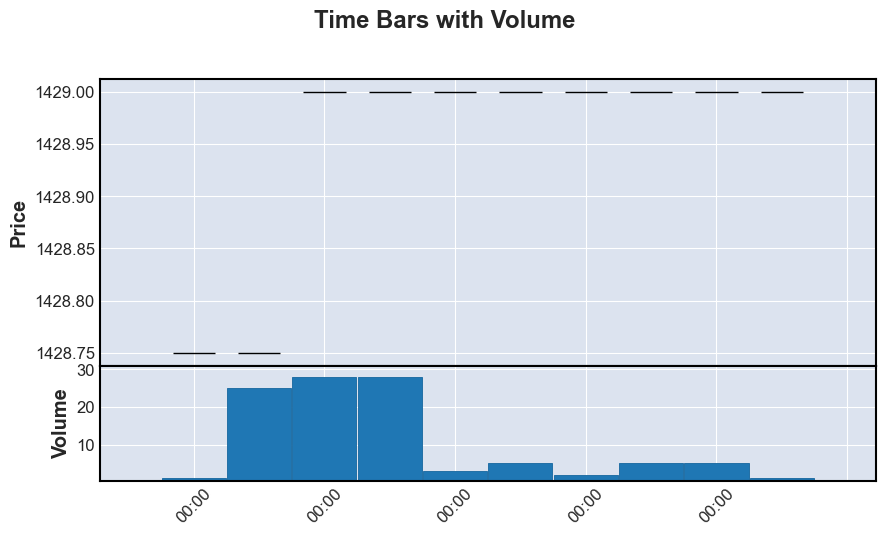

In [5]:
# Define the plot
mpf.plot(time_bars[:10], type='candle', volume=True,
         title='Time Bars with Volume',
         ylabel='Price', ylabel_lower='Volume',
         figratio=(15, 8), mav=(10, 20, 30))

# show the plot
plt.show()

As you can see in the above plot, a new time bar is formed every 100 milliseconds with different volumes. We can use this time bar data to calculate order flow using the bulk volume classification method.

<a id='volumebars'></a>
## Create Volume bars
The volume bars represent price movements over a set volume of trading. Each bar represents a specific amount of trading volume, such as 1,000 contracts or 10,000 contracts. Let's create volume bars with a threshold of 100. Each volume bar would be created for periods where the trading volume exceeds a certain threshold. In this case, the threshold is 100 contracts.  

In [6]:
# Define volume threshold
threshold = 100


The calculation of volume bars using python involves four steps. 
![volume_bars.jpg](https://d2a032ejo53cab.cloudfront.net/Glossary/sREjPgU1/Untitled-Diagram.jpg) <br>

### Cumulative Volume
**Step-1**: Calculate cumulative volume of trades

In [7]:
# Calculate cumulative volume
tick_data['cumulative_volume'] = tick_data['trade_size'].cumsum()

### Initialise Variables
**Step-2**: Initialise the variables `start_time`, `end_time`, `volume_sum` and `volume_bars`. <br><br>
    * `start_time`: To store the starting time of the volume bar.<br>
    * `end_time`: To store the ending time of the volume bar.<br>
    * `volume_sum`: To store the total volume of a volume bar. <br>
    * `volume_bars`: A list of dictionaries to store the volume bars data.<br>
    

In [8]:
# Initialise variables start_time, end_time, volume_sum and volume_bars
start_time = None
end_time = None
volume_sum = 0
volume_bars_list = []

### Iterate over the Trades
**Step-3**: Iterate over the trades in `tick_data` dataframe. Using a `for` loop and `iterrows()` method, create volume bars by accumulating trade volumes until a threshold of 100 is reached. The `iterrows()` function is used to create an iterator which returns an index value and the corresponding row as a Series object.
* If the volume threshold is reached, calculate OHLC (open, high, low, close) data for the volume bar, create a dictionary with this data, and append it to a list of volume bars called 'volume_bars'. 
* Once a volume bar is created, reset the variables `start_time`, `end_time`, and `volume_sum`

In [9]:
# Create a column 'time' to store the trade entry timestamps
tick_data['time'] = pd.to_datetime(tick_data.index)


# Iterate over rows
for index, row in tick_data.iterrows():

    # Check whether the 'volume_sum' variable is equal to zero to confirm start of new volume bar
    if volume_sum == 0:

        # If a new volume bar is starting, 'start_time' variable is set to the value in the 'time' column of the current row
        start_time = row['time']

    # Add volume to sum: Add the value in the 'trade_size' column of the current row to the 'volume_sum' variable
    volume_sum += row['trade_size']

    # Check whether the 'volume_sum' variable is greater than or equal to the 'threshold' value
    if volume_sum >= threshold:

        # If a volume threshold is reached, the 'end_time' variable is set to the value in the 'time' column of the current row
        end_time = row['time']

        # Create a dictionary called 'volume_data' that contains the OHLC data for the current volume bar
        volume_data = {

            # The 'start_time' key is set to the value of 'start_time' variable
            'start_time': start_time,

            # The 'end_time' key is set to the value of 'end_time' variable
            'end_time': end_time,

            # The 'open_price' key is set to the first value in the 'trade_price' column of the row
            # where the 'time' column is equal to the 'start_time' variable
            'open_price': tick_data.loc[tick_data['time'] == start_time, 'trade_price'].iloc[0],

            # The 'high_price' key is set to the maximum value in the 'trade_price' column for rows
            # where the 'time' column is between the 'start_time' and 'end_time' variables
            'high_price': tick_data.loc[start_time:end_time, 'trade_price'].max(),

            # The 'low_price' key is set to the minimum value in the 'trade_price' column for rows
            # where the 'time' column is between the 'start_time' and 'end_time' variables
            'low_price': tick_data.loc[start_time:end_time, 'trade_price'].min(),

            # The 'close_price' key is set to the first value in the 'trade_price' column of the row
            # where the 'time' column is equal to the 'end_time' variable
            'close_price': tick_data.loc[tick_data['time'] == end_time, 'trade_price'].iloc[0],

            # The 'volume' key is set to the value of the 'volume_sum' variable
            'volume': volume_sum
        }

        # Append 'volume_data' dictionary to a list called 'volume_bars_list'
        # which contains the OHLC data for each volume bar.
        volume_bars_list.append(volume_data)

        # Resets the 'start_time', 'end_time', and 'volume_sum' variables to None,
        # which prepares the script to start calculating the next volume bar
        start_time = None
        end_time = None
        volume_sum = 0

# Total number of volume bars created
print(
    f'The total number of volume bars created from {len(tick_data)} trades: {len(volume_bars_list)}')

The total number of volume bars created from 77390 trades: 9550


9550 volume bars are created from the `tick_data` with 77390 trades.

### Create Volume Bars Dataframe
**Step-4**: Convert the `volume_bars_list` into a `volume_bars` dataframe with columns `start_time`, `end_time`, `open`, `high`, `low`,`close`, and `volume`.

In [10]:
# Convert the list of volume bars to dataframe
volume_bars = pd.DataFrame(volume_bars_list)

# Define columns of the volume_bars dataframe
volume_bars.columns = ['start_time', 'end_time', 'open', 'high', 'low',
                       'close', 'volume']

# Set the start time of the volume bars as the index of the volume_bars dataframe
volume_bars.index = volume_bars.start_time

# Print first 5 volume bars
volume_bars.head()

,start_time,end_time,open,high,low,close,volume
start_time,,,,,,,
2013-10-02 00:00:00.604800,2013-10-02 00:00:00.604800,2013-10-02 00:00:44.150400,1428.75,1429.0,1428.75,1429.00,102.0
2013-10-02 00:00:47.433600,2013-10-02 00:00:47.433600,2013-10-02 00:04:16.521599,1429.00,1429.0,1428.75,1429.00,158.0
2013-10-02 00:04:16.521599,2013-10-02 00:04:16.521599,2013-10-02 00:05:17.692800,1429.00,1429.0,1428.00,1428.00,104.0
2013-10-02 00:05:23.049600,2013-10-02 00:05:23.049600,2013-10-02 00:10:35.558400,1428.25,1429.0,1428.00,1428.25,101.0
2013-10-02 00:10:46.790400,2013-10-02 00:10:46.790400,2013-10-02 00:13:21.792000,1429.00,1429.0,1428.50,1429.00,166.0


The function to calculate the volume bars (`volume_bars()`) is added in the `tmf_utils.py` file in the `data_modules` of the `TMFResources.zip`. You can download this `TMFResources.zip` file from the last section of this course.

<a id='plotvolumebars'></a>
## Plot the Volume Bars
Using the `mplfinance` library, create a candlestick chart with volume using the OHLC data from the previously created volume bars dataframe.

Use the `plot()` method of mplfinance with `candle` as the type of plot and `volume` set to True to plot a candlestick chart with volumes.

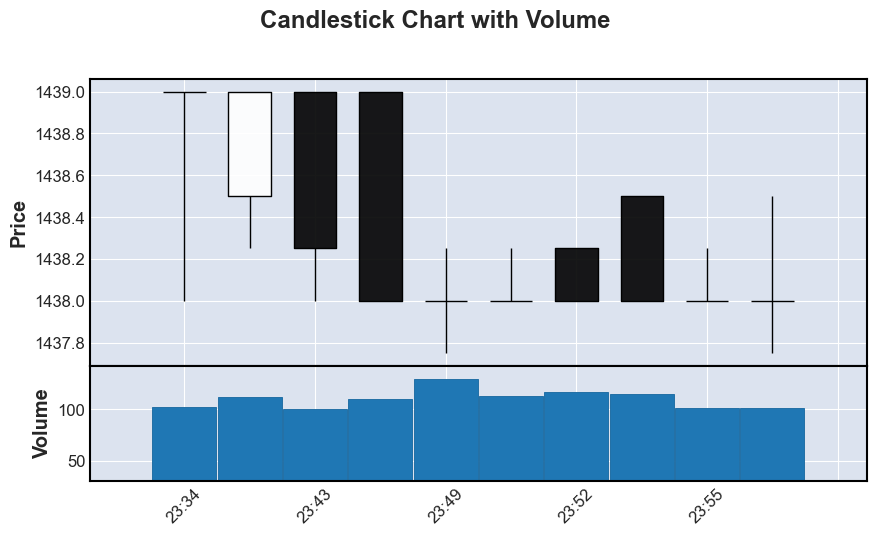

In [11]:
# Define the plot
mpf.plot(volume_bars[-10:], type='candle', volume=True,
         title='Candlestick Chart with Volume',
         ylabel='Price', ylabel_lower='Volume',
         figratio=(15, 8), mav=(10, 20, 30))

The above plot represents the volume bars with a threshold of 100. As you can see, the volume of each bar is almost the same but the timestamps are not equally spaced. 
<a id='conclusion'></a>
## Conclusion and Next Steps

In this notebook, you have learnt to create 100 milliseconds time bars and volume bars (with 100 as threshold) from tick data.  It is recommended to use volume bar data to calculate order flow using BVC method since volume bars provide a more direct measure of the level of trading activity in the market.<br> As an exercise, you can use the same code to create 15-min or 1-hour time bars and volume bars with 1000 as threshold. 

In the next notebook, you will learn to calculate order flow using bulk volume classification method for time bars and volume bars. <br><br>
